# Academic Institution: SimpliLearn

###    Program:  PG AI
###   Course No.8:  Reinforcement  Learning 
###    Course End Project : Stock Trading Using Deep Q-Learning
###    Learner : Chaitanya Kumar Battula
###    Academic Advisior:   Nitin Gujral
###   Submitted on : 02-Sep-2021 

#  Tasks

## 1]  Import   python Libraries
## 2]  Import data sets
## 3]  Define Miscellaneous Functions
## 4]  Create a DQN agent,
####  3.1) create a class called agent 
(1) Action size is defined as 3

(2) Experience replay memory to deque is 1000

(3) There shall be a Empty list for stocks that have already been bought
#### 3.2)  The agent must possess the following hyperparameters:
(1) gamma= 0.95

(2) epsilon = 1.0

(3) epsilon_final = 0.01

(4) epsilon_decay = 0.995

(5) Neural network shall have  3 hidden layers

(6) Action and experience replay are defined


## 5]   Train the agent
## 6]   Evaluate the agent
## 7]  Learners  Comments

# 1]  Import   python Libraries

In [1]:
import sys

import pandas as pd
import numpy as np
import math
import random
from datetime import datetime
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque

print("< OUTPUT >")
print("Completed importing Python Libraries")

< OUTPUT >
Completed importing Python Libraries


# 2]  Load  Data Sets

In [2]:
train_data_set     = "GSPC_Training_Dataset"  
test_data_set      = "GSPC_Evaluation_Dataset"

print("< OUTPUT >")
print("Completed importing Train and Test Datasets. ")

< OUTPUT >
Completed importing Train and Test Datasets. 


# 3]  Define Miscellaneous Functions 

In [3]:
def formatPrice(n):
    return("\t-$ " if n<0 else "$ ")+"{0:.0f}".format(abs(n))


def getStockDataVec(key):
    vec = []
    lines = open(key+".csv","r").read().splitlines()
    for line in lines[1:]:
        #print(line)
        #print(float(line.split(",")[4]))
        vec.append(float(line.split(",")[4]))
        #print(vec)
    return vec 


def sigmoid(x):
    return 1/(1+math.exp(-x))


def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])


def convert_timedelta(start, end):
    duration = end-start
    days, seconds = duration.days, duration.seconds
    hours = days * 24 + seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = (seconds % 60)
    return days, hours, minutes

# 4] Creating   DQN  Agent

In [4]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model(model_name) if is_eval else self._model()
        

    
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    
    
    def act(self, state):
        if not self.is_eval and random.random()<= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])

    
    
    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

#  5.1]   Train  the  Agent

In [5]:
window_size    = 10
episode_count  = 50
batch_size     = 32   
TOTAL_profit   = []
Training_time  = []

agent          = Agent(window_size)
data           = getStockDataVec(train_data_set)
l              = len(data) - 1
START          = datetime.now()


for e in range(episode_count + 1):
    state            = getState(data, 0, window_size + 1)
    total_profit     = 0
    agent.inventory  = []
    for t in range(l):
        action     = agent.act(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward     = 0
        if action == 1: # buy
            agent.inventory.append(data[t])
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = window_size_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += round((data[t] - bought_price),0)
            
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        print("< OUTPUT >")
        if done:
            TOTAL_profit.append(total_profit)
            if(total_profit>0):
                print('Episode:{}/50\tProfit: $ {}'.format(e, total_profit))
                f = open('Training Summary.txt','a')
                f.write("Episode No: "+str(e)+" Profit: " + str(total_profit)+'\n')        
            else:
                print('Episode:{}/50\t\t\tLoss: \t-$ {}'.format(e, abs(total_profit)))
                f = open('Training Summary.txt','a')
                f.write("Episode No: "+str(e)+" \t\tLoss: " + str(total_profit)+'\n')
            
            
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)
    
    if e>10 and total_profit >10000:  
        agent.model.save("DQN-" + str(e)+".hdf5")

        

print("*********************************************")
print("*********************************************")
print("DQN  Traing Completed.\n Please Evaluate the agent based on best model.")    
END = datetime.now()
days, hours, minutes = convert_timedelta(START, END)
print('Total training time :{} days, {} hours, {} minutes '.format(days, hours, minutes))


< OUTPUT >

Episode:0/50			Loss: 	-$ 8452
Episode:1/50	Profit: $ 7938
Episode:2/50			Loss: 	-$ 9426
Episode:3/50	Profit: $ 6358
Episode:4/50			Loss: 	-$ 7004
Episode:5/50	Profit: $ 3837
Episode:6/50			Loss: 	-$ 5402
Episode:7/50	Profit: $ 2125
Episode:8/50	Profit: $ 239
Episode:9/50			Loss: 	-$ 3106
Episode:10/50			Loss: 	-$ 209
Episode:11/50			Loss: 	-$ 186
Episode:12/50			Loss: 	-$ 1341
Episode:13/50			Loss: 	-$ 0
Episode:14/50			Loss: 	-$ 0
Episode:15/50			Loss: 	-$ 0
Episode:16/50			Loss: 	-$ 0
Episode:17/50			Loss: 	-$ 201
Episode:18/50	Profit: $ 180
Episode:19/50	Profit: $ 122
Episode:20/50	Profit: $ 273
Episode:21/50			Loss: 	-$ 458
Episode:22/50			Loss: 	-$ 317
Episode:23/50			Loss: 	-$ 496
Episode:24/50			Loss: 	-$ 637
Episode:25/50			Loss: 	-$ 0
Episode:26/50	Profit: $ 325
Episode:27/50			Loss: 	-$ 409
Episode:28/50	Profit: $ 628
Episode:29/50			Loss: 	-$ 0
Episode:30/50	Profit: $ 1659
Episode:31/50	Profit: $ 207
Episode:32/50			Loss: 	-$ 0
Episode:33/50	Profit: $ 2471
Episod

#   5.2]  DQN   Training    Progress  
####  Plot : Profit  Vs  Episode 

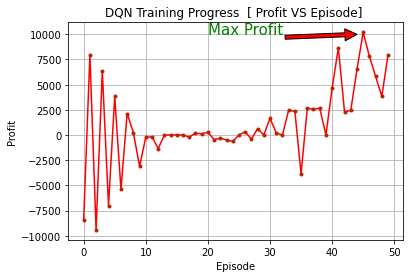

<Figure size 432x288 with 0 Axes>

In [6]:
plt.plot(TOTAL_profit,  color = 'r', marker = 'o',  ms =3, mfc='g', mec='r')
 
plt.title("DQN Training Progress  [ Profit VS Episode] ")
plt.xlabel("Episode")
plt.ylabel("Profit")
plt.annotate('Max Profit', xy = (44, 10000), 
             fontsize = 15, xytext = (20, 10000), 
             arrowprops = dict(facecolor = 'red'),
             color = 'g')
plt.grid()
plt.show()

plt.savefig('DQN Training Progress.png', dpi=300) 
plt.savefig('DQN Training Progress.pdf') 

#### Learners Observation:-
From the plot, we can see that episode 45 yields a model,  with higest profit.

Model 'DQN-45.hdf5 is generated at Episode No.45.

This shall be used, for evaluating the agent, in the next step.

# 6]  Evaluate    Agent 

####   Model with highest prfit is  'DQN-45.hdf5'
####   Use the same for evauating  the agent

In [7]:
model_name      = 'DQN-45.hdf5'
batch_size      = 32

model           = load_model(model_name)
window_size     = model.layers[0].input.shape.as_list()[1]
agent           = Agent(window_size, True, model_name)
data            = getStockDataVec(test_data_set)
l               = len(data) - 1
state           = getState(data, 0, window_size + 1)
total_profit    = 0
agent.inventory = []

for t in range(l):
    action = agent.act(state)
    print("Predicted action:", action)
    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward     = 0
    if action == 1: # buy
        agent.inventory.append(data[t])
        print("Buy: " + formatPrice(data[t]))
    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        reward       = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("--------------------------------")
        print("DQN Evaluation Results")
        print("--------------------------------")
        print("Data set:", test_data_set)
        print("Total profit is:",formatPrice(total_profit))

Predicted action: 1
Buy: $ 1272
Predicted action: 1
Buy: $ 1270
Predicted action: 0
Predicted action: 1
Buy: $ 1274
Predicted action: 1
Buy: $ 1272
Predicted action: 1
Buy: $ 1270
Predicted action: 2
Sell: $ 1274 | Profit: $ 3
Predicted action: 2
Sell: $ 1286 | Profit: $ 16
Predicted action: 1
Buy: $ 1284
Predicted action: 2
Sell: $ 1293 | Profit: $ 19
Predicted action: 2
Sell: $ 1295 | Profit: $ 24
Predicted action: 2
Sell: $ 1282 | Profit: $ 12
Predicted action: 1
Buy: $ 1280
Predicted action: 0
Predicted action: 0
Predicted action: 1
Buy: $ 1291
Predicted action: 0
Predicted action: 0
Predicted action: 2
Sell: $ 1276 | Profit: 	-$ 7
Predicted action: 0
Predicted action: 0
Predicted action: 1
Buy: $ 1304
Predicted action: 0
Predicted action: 0
Predicted action: 0
Predicted action: 0
Predicted action: 0
Predicted action: 0
Predicted action: 0
Predicted action: 0
Predicted action: 1
Buy: $ 1328
Predicted action: 0
Predicted action: 0
Predicted action: 0
Predicted action: 1
Buy: $ 1315


Predicted action: 2
Sell: $ 1254 | Profit: $ 25
Predicted action: 2
Sell: $ 1265 | Profit: $ 12
Predicted action: 0
Predicted action: 0
Predicted action: 0
--------------------------------
DQN Evaluation Results
--------------------------------
Data set: GSPC_Evaluation_Dataset
Total profit is: $ 16


# 7]  Learners  Comments

1) Have tried hyper tuning the gamma = 0.95, epsilon_min = 0.01 and epsilon_decay = 0.995, but did not find any appreciiable change in the training.


2) I traiend the agent for 50 episodes during which 27no profitable models surfaced.
I picked up a model which made a highest profit of 10,206$  and used it for evaluating the agent.


3) During evaluation phase- there was a profit of just 16$. 

--> The fact that there is a profit however small it is, indicates that the training went in the right direction.

--> But, such a small profit indicates, that the agent definitely requires a lot more training.

--> While 50 episodes took about 4 days, then 200 episodes would require 16 days. 

Therefore I could not re-train the agent further with more number of episodes, as of now.

I shall endeavour to improve the model in near feature, whenever I am equipped with a higher processing capability hardware.





>  End Of The Project 